In [33]:
!nvidia-smi
# Find the PID of the process using GPU and kill it:


Fri Aug  8 13:28:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.51.03              Driver Version: 575.51.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:09:00.0 Off |                    0 |
| N/A   73C    P0             66W /   70W |   14881MiB /  15360MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
#!/usr/bin/env python
# coding: utf-8

import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep

hep.style.use("CMS")
plt.rcParams["figure.dpi"] = 400

import json

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

pd.set_option("display.max_columns", None)

# import argparse

# parser = argparse.ArgumentParser(description="Transformer Training Script")
# parser.add_argument(
#     "--output_dir",
#     type=str,
#     help="Data output directory",
# )
# parser.add_argument(
#     "--bamboo_results_dir",
#     type=str,
#     default="/eos/user/a/aguzel/bamboo-output/v1.3.0-2022-cf/results/",
#     help="Directory containing the Bamboo results",
# )
# parser.add_argument(
#     "--n_events",
#     type=int,
#     default=10_000,
#     help="Number of events to process (default: 1e4)",
# )
# parser.add_argument(
#     "--n_epochs",
#     type=int,
#     default=50,
#     help="Number of epochs for training (default: 50)",
# )
# parser.add_argument(
#     "--lr",
#     type=float,
#     default=1e-3,
#     help="Learning rate for the optimizer (default: 1e-3)",
# )
# parser.add_argument(
#     "--wd",
#     type=float,
#     default=1e-3,
#     help="Weight decay for the optimizer (default: 1e-3)",
# )
# parser.add_argument(
#     "--noise_level",
#     type=float,
#     default=0.,
#     help="Level of noise to add to the input features (default: 0, no noise)",
# )
# args = parser.parse_args()

output_dir = "test-1"
bamboo_results_dir = ["/eos/user/a/aguzel/bamboo-output/newMLvars-cutflow-2022/results/"]#,
                    #   "/eos/user/a/aguzel/bamboo-output/newMLvars-cutflow-2023/results/"]
N = 1e3
N = int(N)  # Convert to integer for consistency
noise_level = 0.01

In [35]:

os.makedirs(f"{output_dir}", exist_ok=True)

batch_size = 1024

print(f"Using {output_dir} as output directory\n")
print(f"Batch size: {batch_size}\n")
if N > 1e6:
    print("Taking all events")
    print("(N =", N, ")\n")
else:
    print("Taking N =", N, " events\n")


def listFiles(prefixes):
    return [
        file for file in rootFiles if any(file.split("/")[-1].startswith(p) for p in prefixes)
    ]

# get the data files
rootFiles = []
for path in bamboo_results_dir:
    for file in os.listdir(path):
       rootFiles.append(os.path.join(path, file))

TT_files = listFiles(["TT"])
DY_files = listFiles(["DY"])
other_bkg_files = listFiles(["Tbar", "TW", "W", "Z"])
HH_files = listFiles(["ggH"])
VBF_files = listFiles(["VBF"])

config_dict = {
    "output_dir": output_dir,
    "bamboo_results_dir": bamboo_results_dir,
    "n_events": N,
    "noise_level": noise_level,
    "root_files": rootFiles,
    "TT_files": TT_files,
    "DY_files": DY_files,
    "other_bkg_files": other_bkg_files,
    "HH_files": HH_files,
}

with open(f"{output_dir}/config.json", "w") as f:
    json.dump(config_dict, f, indent=4)
print(f"Saved config to {output_dir}/config.json")

print("Number of TT root files:", len(TT_files))
print("Number of DY root files:", len(DY_files))
print("Number of other_bkg root files:", len(other_bkg_files))
print("Number of HH root files:", len(HH_files))
print("Number of VBF root files:", len(VBF_files))


treenames = [
    "DL_resolved_1b_ee_ml_vars;1",
    "DL_resolved_1b_mumu_ml_vars;1",
    "DL_resolved_1b_emu_ml_vars;1",
    "DL_resolved_2b_ee_ml_vars;1",
    "DL_resolved_2b_mumu_ml_vars;1",
    "DL_resolved_2b_emu_ml_vars;1",
    "DL_boosted_ee_ml_vars;1",
    "DL_boosted_mumu_ml_vars;1",
    "DL_boosted_emu_ml_vars;1",
]

# The variables for each object (here l1, l2, j1, j2, j3, j4, j8(ak8) and met)
input_features = {
    "lepton_1": [
        "l1_Px",
        "l1_Py",
        "l1_Pz",
        "l1_E",
        "l1_pdgId",
        "l1_charge",
        "leading_lepton_pt",
    ],
    "lepton_2": [
        "l2_Px",
        "l2_Py",
        "l2_Pz",
        "l2_E",
        "l2_pdgId",
        "l2_charge",
        "subleading_lepton_pt",
    ],
    "jet_1": ["j1_Px", "j1_Py", "j1_Pz", "j1_E", "j1_btag"],
    "jet_2": ["j2_Px", "j2_Py", "j2_Pz", "j2_E", "j2_btag"],
    "jet_3": ["j3_Px", "j3_Py", "j3_Pz", "j3_E", "j3_btag"],
    "jet_4": ["j4_Px", "j4_Py", "j4_Pz", "j4_E", "j4_btag"],
    "jet_8": [
        "j8_Px",
        "j8_Py",
        "j8_Pz",
        "j8_E",
        "j8_btag",
        "j8_tau1",
        "j8_tau2",
        "j8_tau3",
        "j8_tau4",
        "j8_msoftdrop",
    ],
    "met": ["met_Px", "met_Py", "met_E"],  # , "met_LD", "HT"], include these
    "misc": [
        "dR_l1_l2",
        "dR_j1_j2",
        "dR_dilepton_dijet",
        "dR_dilepton_dibjet",
        "abs_dphi_met_dilepton",
        "min_dR_l1_ak4jets",
        "min_dR_l2_ak4jets",
        "min_dR_lead_bjet_leptons",
        "min_dR_sublead_bjet_leptons",
        "min_dR_ak4jets",
        "min_abs_dphi_ak4jets",
        "di_bjet_mass",
        "di_lepton_mass",
        "di_lepton_met_mass",
        "VBF_tag",
        "boosted_tag",
        "run_year",
    ],
}

n_features = sum([len(val) for val in input_features.values()])

print("\nNumber of input features:", n_features)
print(f"which are: {[value for value in input_features.values()]}\n")

processes = ["HH", "bkg"]

target_set = [
    "HH",
]

Using test-1 as output directory

Batch size: 1024

Taking N = 1000  events

Saved config to test-1/config.json
Number of TT root files: 2
Number of DY root files: 4
Number of other_bkg root files: 12
Number of HH root files: 8
Number of VBF root files: 2

Number of input features: 64
which are: [['l1_Px', 'l1_Py', 'l1_Pz', 'l1_E', 'l1_pdgId', 'l1_charge', 'leading_lepton_pt'], ['l2_Px', 'l2_Py', 'l2_Pz', 'l2_E', 'l2_pdgId', 'l2_charge', 'subleading_lepton_pt'], ['j1_Px', 'j1_Py', 'j1_Pz', 'j1_E', 'j1_btag'], ['j2_Px', 'j2_Py', 'j2_Pz', 'j2_E', 'j2_btag'], ['j3_Px', 'j3_Py', 'j3_Pz', 'j3_E', 'j3_btag'], ['j4_Px', 'j4_Py', 'j4_Pz', 'j4_E', 'j4_btag'], ['j8_Px', 'j8_Py', 'j8_Pz', 'j8_E', 'j8_btag', 'j8_tau1', 'j8_tau2', 'j8_tau3', 'j8_tau4', 'j8_msoftdrop'], ['met_Px', 'met_Py', 'met_E'], ['dR_l1_l2', 'dR_j1_j2', 'dR_dilepton_dijet', 'dR_dilepton_dibjet', 'abs_dphi_met_dilepton', 'min_dR_l1_ak4jets', 'min_dR_l2_ak4jets', 'min_dR_lead_bjet_leptons', 'min_dR_sublead_bjet_leptons', 'min_dR_

In [36]:
import uproot
from tqdm import tqdm

# Collect all input feature names into a flat list
feature_list = [item for sublist in input_features.values() for item in sublist]


class CustomData:
    def __init__(
        self,
        files,
        type,
        treenames,
        feature_list,
        extra_cols=None,
        n_events=N,
        name="data",
    ):
        self.files = files
        self.type = type
        self.treenames = treenames
        self.feature_list = feature_list.copy()
        if extra_cols:
            self.feature_list += extra_cols
        self.extra_cols = extra_cols
        self.n_events = n_events
        self.name = name

        # Load the data from the files
        self.df = self.load_data()

        # Add one-hot encoded column based on type, and set as int32
        if self.type.lower() == "hh":
            self.df["HH"] = np.int8(1)
            self.df["bkg"] = np.int8(0)
        else:
            self.df["HH"] = np.int8(0)
            self.df["bkg"] = np.int8(1)

    def load_data(self):
        data_frames = []
        for file in tqdm(self.files, desc=f"Loading {self.name} data"):
            with uproot.open(file) as f:
                available_keys = f.keys()
                for treename in self.treenames:
                    # Remove cycle number for matching
                    base_treename = treename.split(";")[0]
                    matched_key = None
                    for key in available_keys:
                        if base_treename in key:
                            matched_key = key
                            break
                    if matched_key is not None:
                        tree = f[matched_key]
                        arrs = tree.arrays(
                            self.feature_list, entry_stop=self.n_events, library="pd"
                        )
                        data_frames.append(arrs)
                    else:
                        print(
                            f"Warning: Tree '{treename}' not found in {file.split('/')[-1]}. Skipping."
                        )
        if data_frames:
            return pd.concat(data_frames, ignore_index=True)
        else:
            return pd.DataFrame()  # Return empty DataFrame if nothing found


extra_cols = ["event_no", "weight"]

DY_df = CustomData(
    DY_files,
    "bkg",
    treenames,
    feature_list,
    extra_cols=extra_cols,
    n_events=N,
    name="DY",
)

TT_df = CustomData(
    TT_files,
    "bkg",
    treenames,
    feature_list,
    extra_cols=extra_cols,
    n_events=N,
    name="TT",
)

other_bkg_df = CustomData(
    other_bkg_files,
    "bkg",
    treenames,
    feature_list,
    extra_cols=extra_cols,
    n_events=N,
    name="Other_bkg",
)

HH_df = CustomData(
    HH_files,
    "HH",
    treenames,
    feature_list,
    extra_cols=extra_cols,
    n_events=N,
    name="ggF_HH",
)

Loading DY data:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

Loading Other_bkg data:  67%|██████▋   | 8/12 [00:14<00:07,  1.89s/it]

Loading Other_bkg data:  83%|████████▎ | 10/12 [00:15<00:02,  1.17s/it]

Loading ggF_HH data: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


In [37]:
# Concatenate DataFrames from CustomData objects in customdata_set
customdata_set = [DY_df, TT_df, other_bkg_df, HH_df]
# customdata_set = [DY_df, HH_df]

for customdata in customdata_set:
    print(customdata.df.shape[0], " events in ", customdata.name)

dfs = [data.df for data in customdata_set]
df = pd.concat(dfs, ignore_index=True)
print(f"\nConcatenated DataFrame shape: {df.shape}")

14178  events in  DY
17971  events in  TT
38210  events in  Other_bkg
55701  events in  ggF_HH

Concatenated DataFrame shape: (126060, 68)


In [38]:
for col, type in df.dtypes.items():
    print(f"Column: {col}, Type: {type}")

Column: l1_Px, Type: float32
Column: l1_Py, Type: float32
Column: l1_Pz, Type: float32
Column: l1_E, Type: float32
Column: l1_pdgId, Type: float32
Column: l1_charge, Type: float32
Column: leading_lepton_pt, Type: float32
Column: l2_Px, Type: float32
Column: l2_Py, Type: float32
Column: l2_Pz, Type: float32
Column: l2_E, Type: float32
Column: l2_pdgId, Type: float32
Column: l2_charge, Type: float32
Column: subleading_lepton_pt, Type: float32
Column: j1_Px, Type: float32
Column: j1_Py, Type: float32
Column: j1_Pz, Type: float32
Column: j1_E, Type: float32
Column: j1_btag, Type: float64
Column: j2_Px, Type: float32
Column: j2_Py, Type: float32
Column: j2_Pz, Type: float32
Column: j2_E, Type: float32
Column: j2_btag, Type: float64
Column: j3_Px, Type: float32
Column: j3_Py, Type: float32
Column: j3_Pz, Type: float32
Column: j3_E, Type: float32
Column: j3_btag, Type: float64
Column: j4_Px, Type: float32
Column: j4_Py, Type: float32
Column: j4_Pz, Type: float32
Column: j4_E, Type: float32
Co

In [39]:
if "event_no" not in df.columns:
    raise KeyError("The DataFrame does not contain 'event_no' column.")

# Add target columns to the data in one-hot encoding
for process in processes:
    for data in customdata_set:
        if data.type == process:
            data.df[process] = np.ones_like(data.df["event_no"])
        else:
            data.df[process] = np.zeros_like(data.df["event_no"])

weight_branch = "weight"

In [40]:
# Make pandas dataframes out of the data
# if N is less than the number of events in the root files, then here
# we're falling into `sample` which shuffles the data since we want
# to take a really random subset. But this approach may improve bias,
# instead stratification should be done or all events should be used.
# df = pd.concat(
#     [data.get_df().sample(n=min(N, len(data.get_df()))) for data in data_set]
# )

# convert tags to integers
df["VBF_tag"] = df["VBF_tag"].astype(np.int8)
df["boosted_tag"] = df["boosted_tag"].astype(np.int8)

# # one-hot encode pdgId and charge of leptons in separate columns
# for lep in ["l1", "l2"]:
#     # pdgId one-hot as integers
#     pdgid_dummies = pd.get_dummies(df[f"{lep}_pdgId"], prefix=f"{lep}_pdgId").astype(int)
#     df = pd.concat([df, pdgid_dummies], axis=1)
#     # charge one-hot as integers
#     charge_dummies = pd.get_dummies(df[f"{lep}_charge"], prefix=f"{lep}_charge").astype(int)
#     df = pd.concat([df, charge_dummies], axis=1)

In [41]:
print("Number of input features after one-hot encoding:", n_features + 4 * 2)

assert df.shape[0] == len(
    df["event_no"]
), "Number of rows in the DataFrame does not match the number of event_no entries"

Number of input features after one-hot encoding: 72


In [42]:
# data cleaning

# Check for infinite or nan values
# Show a boolean DataFrame where inf values are True

# df.drop(
#     columns=["sample", "file", "tree"], inplace=True
# )  # drop event_no column if exists
inf_mask = np.isinf(df.values)

# Get row and column indices of inf values
rows, cols = np.where(inf_mask)

for r, c in zip(rows, cols):
    print(f"Row: {df.index[r]}, Column: {df.columns[c]}, Value: {df.iloc[r, c]}")

# Find rows with inf values
rows_with_inf = np.where(inf_mask)[0]
rows_with_inf = np.unique(rows_with_inf)  # Unique row indices

# Drop those rows
df = df.drop(df.index[rows_with_inf]).reset_index(drop=True)
print(f"Dropped {len(rows_with_inf)} row(s) containing inf values.")

Row: 100786, Column: l2_Pz, Value: inf
Row: 100786, Column: l2_E, Value: inf
Dropped 1 row(s) containing inf values.


In [43]:
# Check for rows where lepton pdgId is not ±11 or ±13
invalid_mask = ~(
    df["l1_pdgId"].abs().isin([11, 13]) &
    df["l2_pdgId"].abs().isin([11, 13])
)
invalid_rows = df[invalid_mask]
print(f"Number of events with invalid lepton pdgId: {invalid_rows.shape[0]}")
print(invalid_rows[["l1_pdgId", "l2_pdgId"]])

Number of events with invalid lepton pdgId: 234
        l1_pdgId  l2_pdgId
7028       -11.0    5460.0
7036        11.0    5353.0
7106        11.0    5379.0
7127       -11.0    5439.0
7161        11.0    5356.0
...          ...       ...
122160     -13.0       0.0
124951     -13.0    5425.0
124953     -13.0    5425.0
125030      11.0       0.0
125051     -13.0       0.0

[234 rows x 2 columns]


In [44]:
# Keep only rows where both leptons have allowed pdgId values
allowed_pdgids = {-11, 11, -13, 13}
mask = df["l1_pdgId"].isin(allowed_pdgids) & df["l2_pdgId"].isin(allowed_pdgids)
print(
    f"Dropping {len(df) - mask.sum()} events with lepton pdgId not in {allowed_pdgids}"
)
df = df[mask].reset_index(drop=True)

# Drop events where either lepton has a charge not equal to -1 or 1
allowed_charges = {-1, 1}
charge_mask = df["l1_charge"].isin(allowed_charges) & df["l2_charge"].isin(
    allowed_charges
)
print(
    f"Dropping {len(df) - charge_mask.sum()} events with lepton charge not in {allowed_charges}"
)
df = df[charge_mask].reset_index(drop=True)

from scipy.stats import zscore

numeric_df = df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(numeric_df, nan_policy="omit"))
threshold = 10
# experimentally z score of 10 gives around 1% of the outliers
outlier_mask = z_scores > threshold

outlier_rows = df[(outlier_mask).any(axis=1)]
print(f"Number of rows with outliers (z-score > {threshold}): {outlier_rows.shape[0]}")

# Drop outlier rows from the dataframe
df.drop(outlier_rows.index, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Outliers dropped.")

Dropping 234 events with lepton pdgId not in {-11, 11, 13, -13}
Dropping 0 events with lepton charge not in {1, -1}
Number of rows with outliers (z-score > 10): 571
Outliers dropped.


In [45]:
# Need to cut out negative weights #
print(
    f"\nTotal weight sum = {df[weight_branch].sum():1.3e}, with {(df[weight_branch]<0).sum()} negative weight events"
)
df = df[df[weight_branch] > 0]
print(
    f"\nAfter cutting out negative weights : total weight sum = {df[weight_branch].sum():1.3e}"
)


Total weight sum = 1.862e+08, with 7414 negative weight events

After cutting out negative weights : total weight sum = 3.287e+08


In [46]:
# In case you restricted the number of events, need to rescale the weights
for process, data_process in zip(processes, customdata_set):
    ratio = (
        data_process.df[weight_branch].sum() / df[df[process] == 1][weight_branch].sum()
    )
    df.loc[df[process] == 1, weight_branch] *= ratio

In [47]:
# Plot the weights before normalisation
plt.hist(
    df[df["HH"] == 1][weight_branch],
    label="Signal (ggF HH)",
    histtype="step",
    linewidth=1,
    bins=100,
    color="blue",
)
plt.hist(
    df[df["bkg"] == 1][weight_branch],
    label="Background",
    histtype="step",
    linewidth=1,
    bins=100,
    color="red",
)
plt.xlabel("Event weight")
plt.xscale("log")
plt.yscale("log")
plt.title(
    "Event weights before normalisation",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=10, fontproperties="Tex Gyre Heros"
)
plt.legend(loc="upper right")
plt.savefig(f"{output_dir}/event_weights.png")
plt.clf()
print(f"\nWeights saved to {output_dir}/event_weights.png")

# Now equalize the sum of weight
print("\nBefore reweighting")
for process in processes:
    print(
        f"{process} : N = {df[df[process]==1].shape[0]:6d}, sum(w) = {df[df[process]==1][weight_branch].sum():1.3e}"
    )

for process in processes:
    df.loc[df[process] == 1, weight_branch] *= (
        df.shape[0] / len(processes) / df[df[process] == 1][weight_branch].sum()
    )

print("After reweighting")
for process in processes:
    print(
        f"{process} : N = {df[df[process]==1].shape[0]:6d}, sum(w) = {df[df[process]==1][weight_branch].sum():1.3e}"
    )

# # Increase the weight for HH events
# df.loc[df["HH"] == 1, weight_branch] *= 5
# print("\nAfter multiplying HH weights by 5")
# for process in processes:
#     print(
#         f"{process} : N = {df[df[process]==1].shape[0]:6d}, sum(w) = {df[df[process]==1][weight_branch].sum():1.3e}"
#     )

# Plot the weights after normalisation
plt.hist(
    df[df["HH"] == 1][weight_branch],
    label="Signal (ggF HH)",
    histtype="step",
    linewidth=1,
    bins=100,
    color="blue",
)
plt.hist(
    df[df["bkg"] == 1][weight_branch],
    label="Background",
    histtype="step",
    linewidth=1,
    bins=100,
    color="red",
)
plt.xlabel("Event weight")
plt.xscale("log")
plt.yscale("log")
plt.title(
    "Event weights after normalisation",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=10, fontproperties="Tex Gyre Heros"
)
plt.legend(loc="upper right")
plt.savefig(f"{output_dir}/normalised_weights.png")
plt.clf()
print(f"\nNormalised weights saved to {output_dir}/normalised_weights.png")


Weights saved to test-1/event_weights.png

Before reweighting
HH : N =  52542, sum(w) = 1.851e+08
bkg : N =  65298, sum(w) = 1.458e+06
After reweighting
HH : N =  52542, sum(w) = 5.892e+04
bkg : N =  65298, sum(w) = 5.892e+04

Normalised weights saved to test-1/normalised_weights.png


<Figure size 4000x4000 with 0 Axes>

In [48]:
# Convert all feature columns to float32 for efficiency
df[feature_list] = df[feature_list].astype(np.float32)
df[weight_branch] = df[weight_branch].astype(np.float32)
df["event_no"] = df["event_no"].astype(np.int64)

In [49]:
for col, type in df.dtypes.items():
    print(col, "    :", type)

l1_Px     : float32
l1_Py     : float32
l1_Pz     : float32
l1_E     : float32
l1_pdgId     : float32
l1_charge     : float32
leading_lepton_pt     : float32
l2_Px     : float32
l2_Py     : float32
l2_Pz     : float32
l2_E     : float32
l2_pdgId     : float32
l2_charge     : float32
subleading_lepton_pt     : float32
j1_Px     : float32
j1_Py     : float32
j1_Pz     : float32
j1_E     : float32
j1_btag     : float32
j2_Px     : float32
j2_Py     : float32
j2_Pz     : float32
j2_E     : float32
j2_btag     : float32
j3_Px     : float32
j3_Py     : float32
j3_Pz     : float32
j3_E     : float32
j3_btag     : float32
j4_Px     : float32
j4_Py     : float32
j4_Pz     : float32
j4_E     : float32
j4_btag     : float32
j8_Px     : float32
j8_Py     : float32
j8_Pz     : float32
j8_E     : float32
j8_btag     : float32
j8_tau1     : float32
j8_tau2     : float32
j8_tau3     : float32
j8_tau4     : float32
j8_msoftdrop     : float32
met_Px     : float32
met_Py     : float32
met_E     : float32

In [50]:
# # Create directory for histograms if it doesn't exist
# hist_dir = f"{output_dir}/column_hists"
# os.makedirs(hist_dir, exist_ok=True)

# # Plot each column as a histogram with linear and log y-scale side by side
# for col in df.columns:
#     fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#     # Linear scale
#     axes[0].hist(df[col], bins=50, color="skyblue")
#     axes[0].set_title(f"{col} (linear)")
#     axes[0].set_xlabel(col)
#     axes[0].set_ylabel("Count")
#     # Log scale
#     axes[1].hist(df[col], bins=50, color="skyblue")
#     axes[1].set_yscale("log")
#     axes[1].set_title(f"{col} (log)")
#     axes[1].set_xlabel(col)
#     axes[1].set_ylabel("Count")
#     plt.tight_layout()
#     fig.savefig(os.path.join(hist_dir, f"{col}_hist.png"))
#     plt.close(fig)
# print(f"Saved all inputs as histograms to {hist_dir}")

In [51]:
# if noise_level > 0.0:
#     # Inject some noise into the numeric columns
#     print("Adding noise.")
#     # List of columns to augment (exclude targets and weights)
#     exclude_cols = ["HH", "bkg", "weight"]

#     numeric_cols = [
#         col
#         for col in df.select_dtypes(include=[np.number]).columns
#         if col not in exclude_cols
#     ]

#     # Set noise which is noise_level % of each column's std

#     # Create augmented dataframe
#     df_aug = df.copy()
#     for col in numeric_cols:
#         std = df[col].std()
#         noise = np.random.normal(0, noise_level * std, size=len(df))
#         df_aug[col] = df[col] + noise

#     # Concatenate augmented data to original
#     df = pd.concat([df, df_aug], ignore_index=True)

In [52]:
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve

# Prepare features and target
exclude_cols = ["HH", "bkg", "weight", "event_no"]
feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols].values
y = df["HH"].values
weights = df["weight"].values

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=seed, stratify=y
)

In [54]:
# Train an XGBoost model

model = xgb.XGBClassifier(
    n_estimators=10,
    learning_rate=0.005,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    device="cpu",
    random_state=seed,
    eval_metric=["logloss", "auc"],
    reg_alpha=0.1,
    reg_lambda=1.0,
)
model.fit(
    X_train,
    y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=1,
)


[0]	validation_0-logloss:0.69231	validation_0-auc:0.71454	validation_1-logloss:0.69230	validation_1-auc:0.71623
[1]	validation_0-logloss:0.69196	validation_0-auc:0.68581	validation_1-logloss:0.69193	validation_1-auc:0.68834
[2]	validation_0-logloss:0.69139	validation_0-auc:0.68879	validation_1-logloss:0.69138	validation_1-auc:0.69018
[3]	validation_0-logloss:0.69026	validation_0-auc:0.70965	validation_1-logloss:0.69023	validation_1-auc:0.71134
[4]	validation_0-logloss:0.68937	validation_0-auc:0.71322	validation_1-logloss:0.68934	validation_1-auc:0.71451
[5]	validation_0-logloss:0.68866	validation_0-auc:0.71396	validation_1-logloss:0.68863	validation_1-auc:0.71493
[6]	validation_0-logloss:0.68777	validation_0-auc:0.71821	validation_1-logloss:0.68772	validation_1-auc:0.71953
[7]	validation_0-logloss:0.68642	validation_0-auc:0.74048	validation_1-logloss:0.68636	validation_1-auc:0.74152
[8]	validation_0-logloss:0.68552	validation_0-auc:0.74021	validation_1-logloss:0.68545	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [55]:
# obtain predictions
y_pred = model.predict_proba(X_test)[:, 1]
results = model.evals_result()

XGBoost ROC AUC: 0.8891


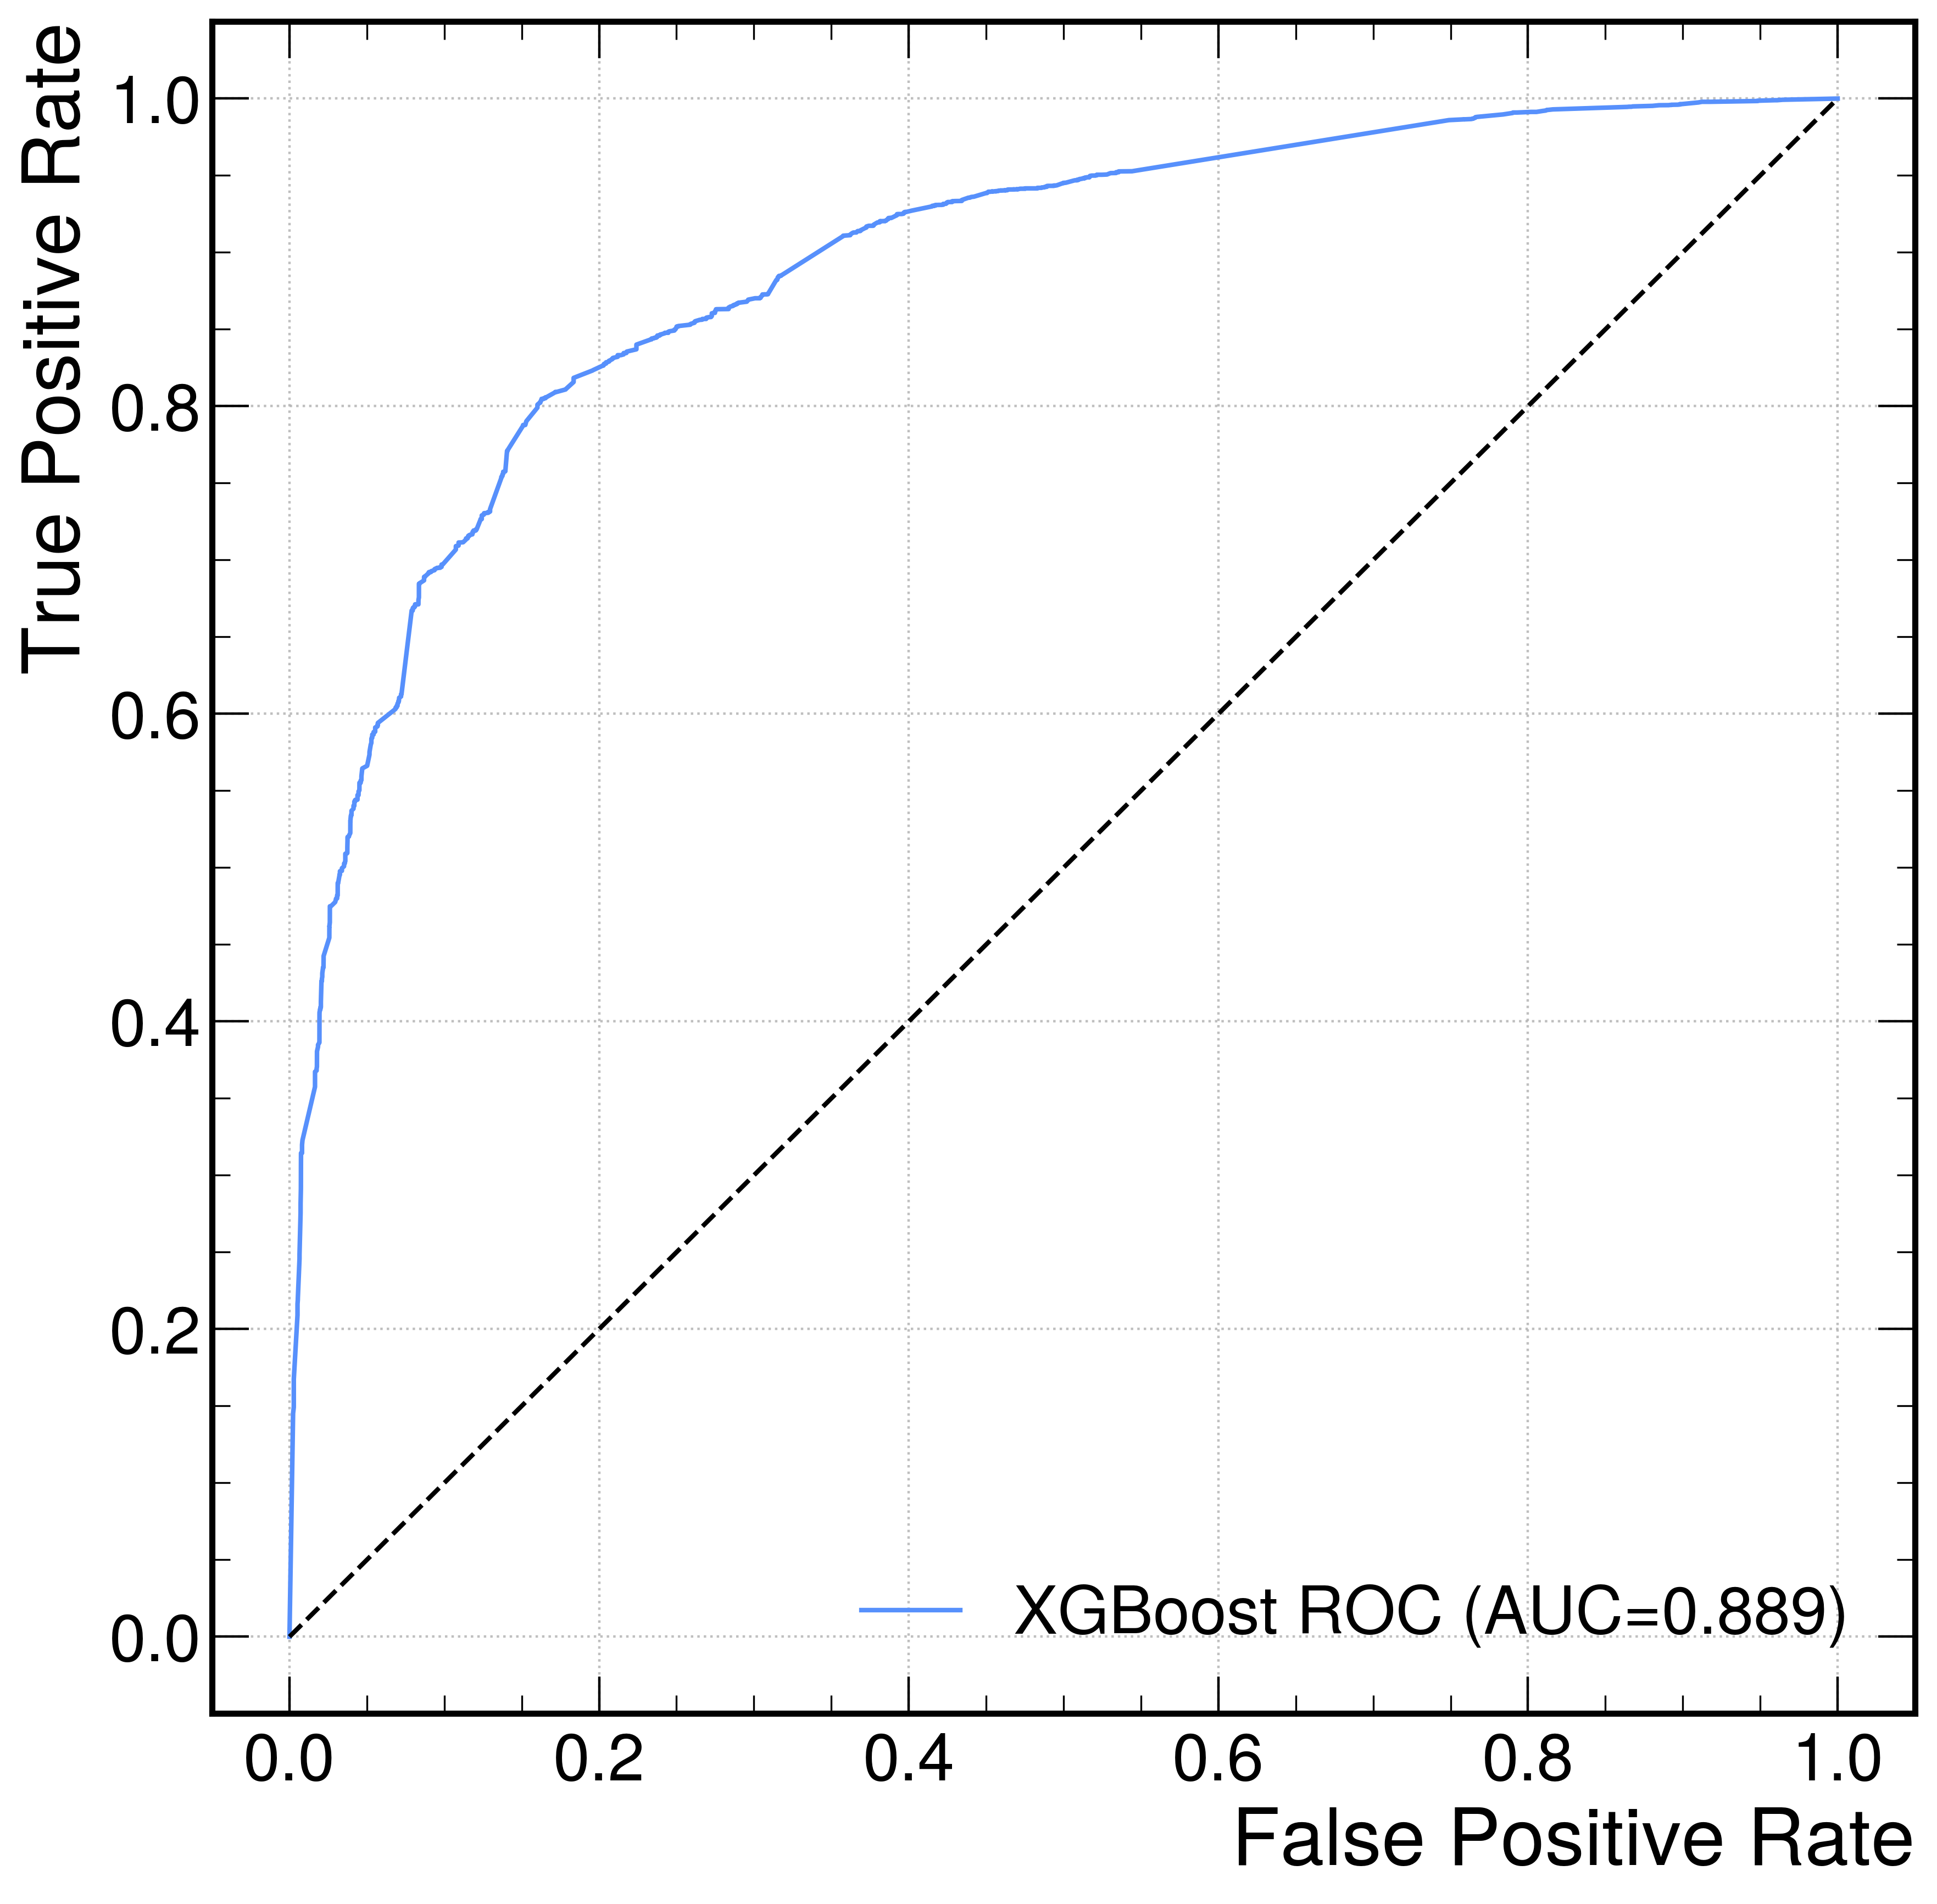

ROC curve saved to test-1/xgb_roc_curve.png


In [56]:
# Predict and evaluate
roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
print(f"XGBoost ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred, sample_weight=weights_test)
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/xgb_roc_curve.png")
plt.show()
print(f"ROC curve saved to {output_dir}/xgb_roc_curve.png")

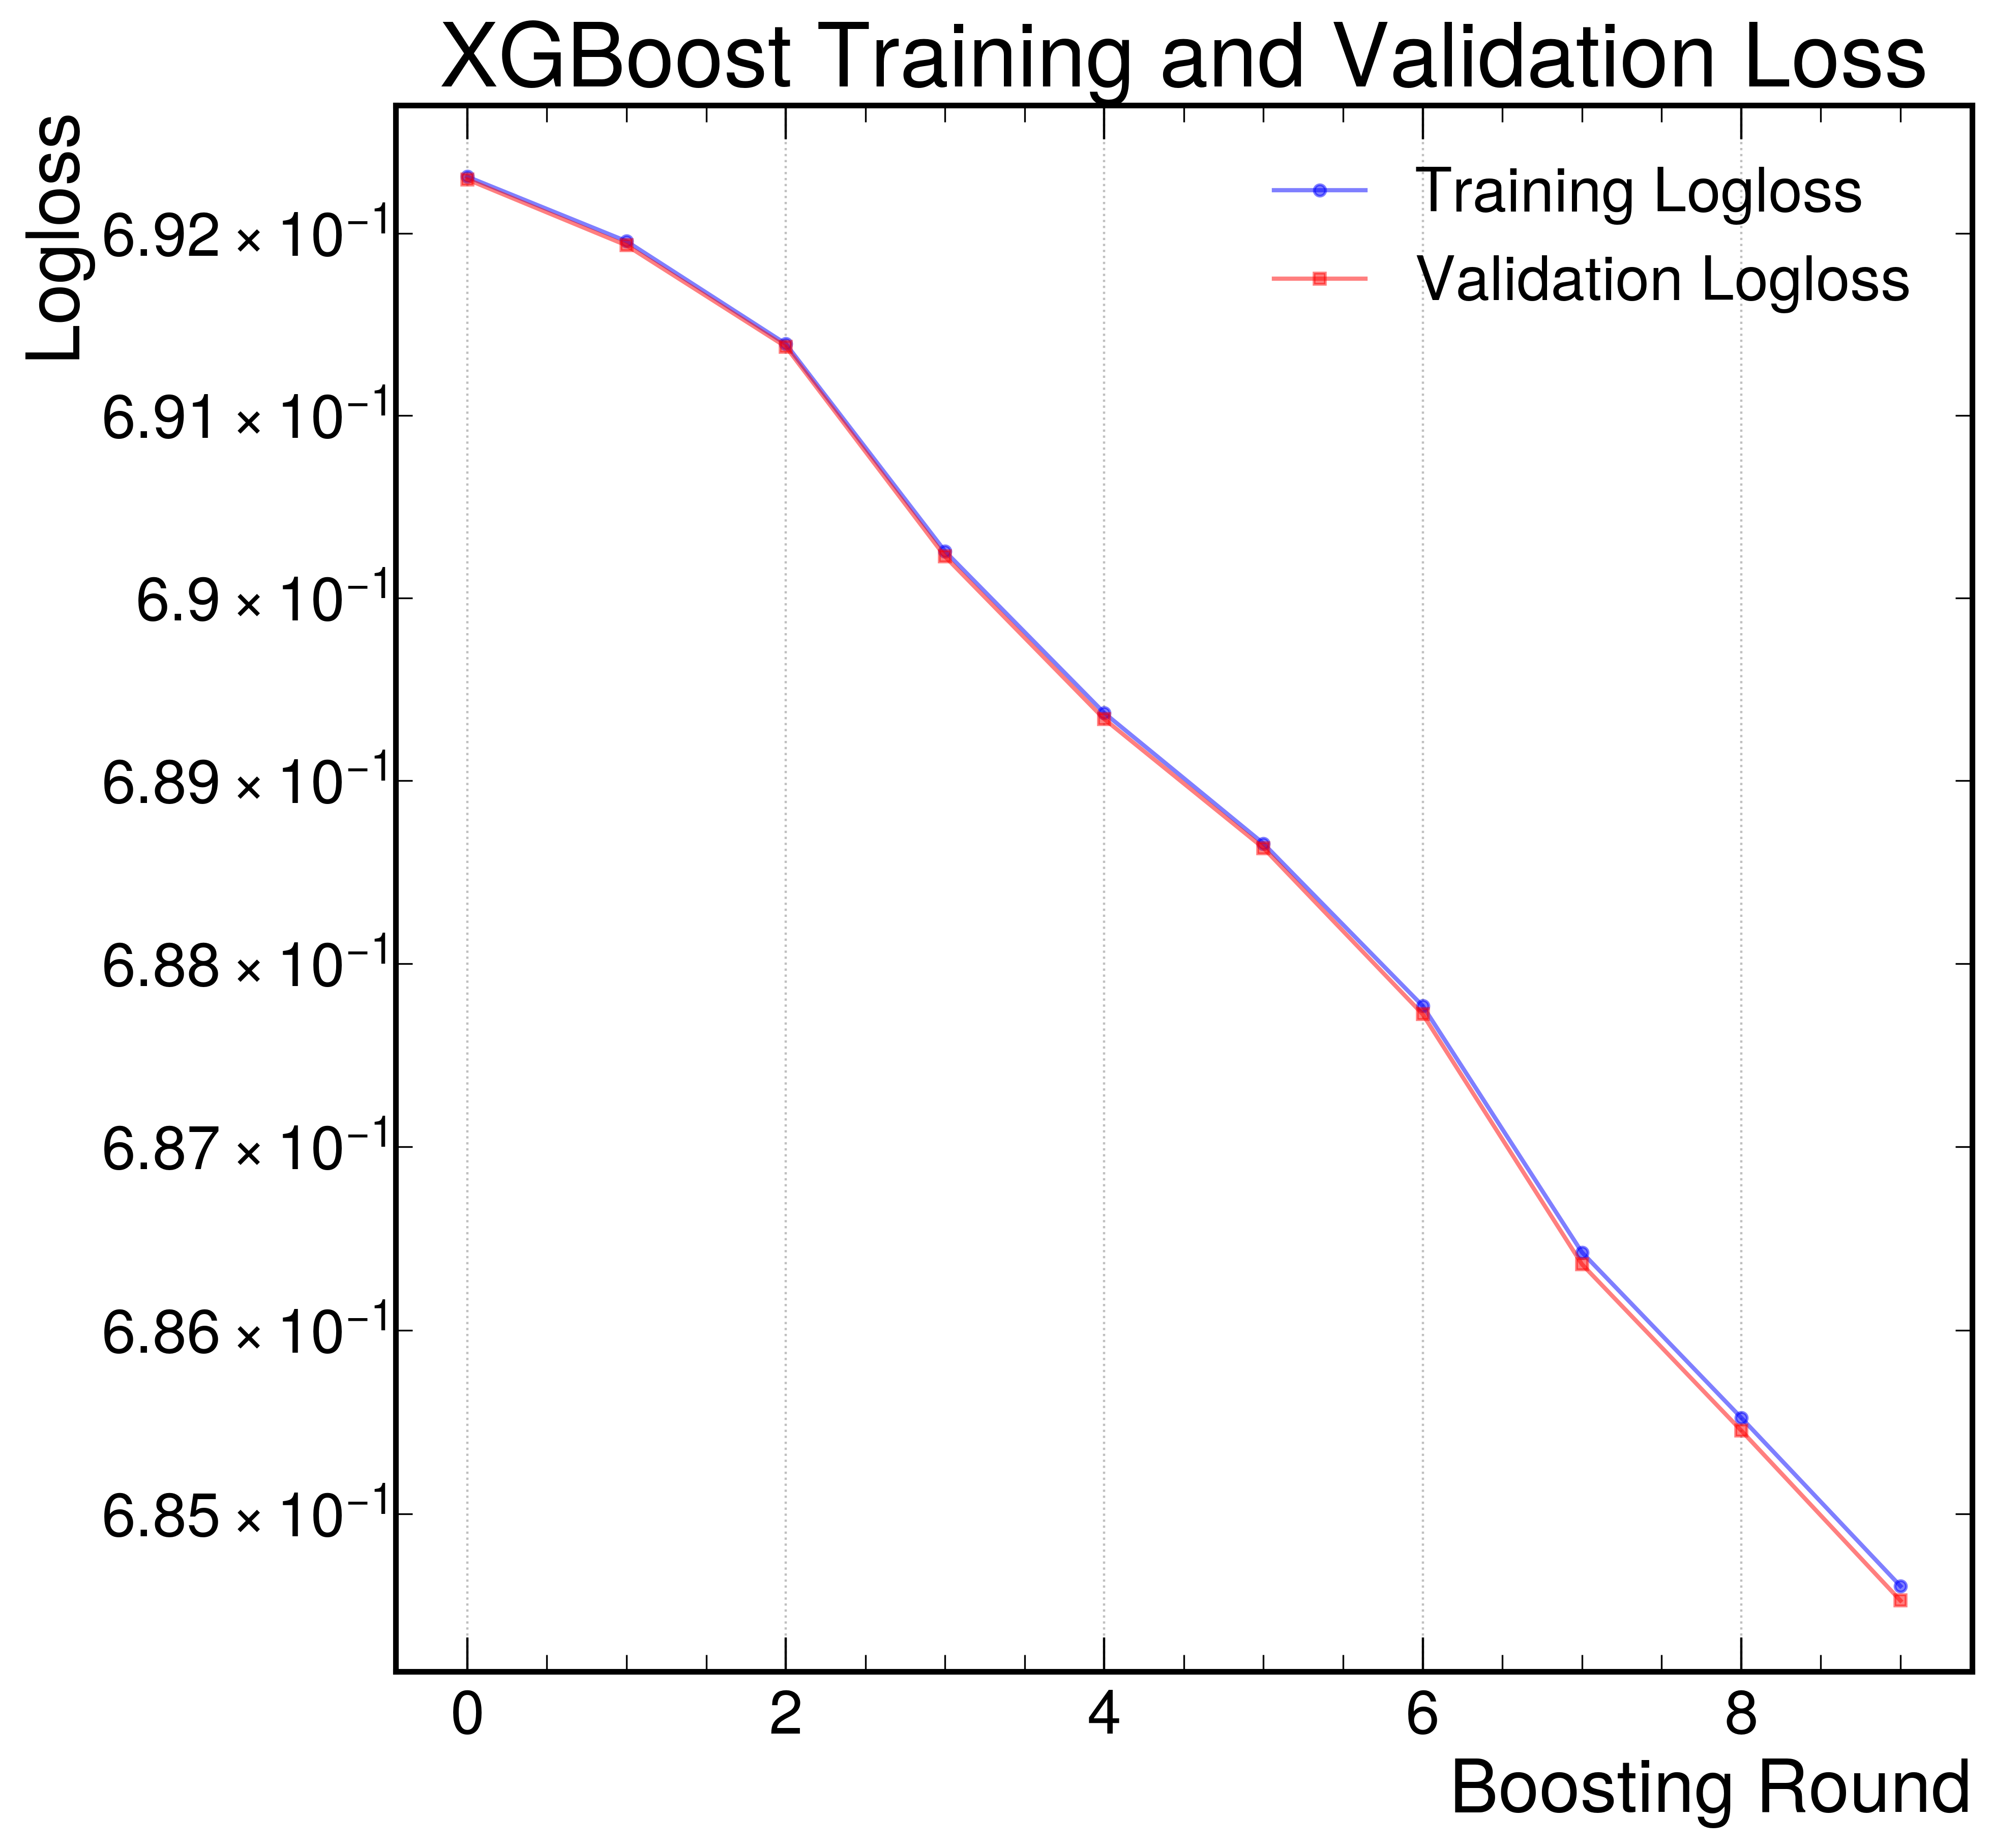

In [57]:
plt.figure()
plt.plot(results["validation_0"]["logloss"], label="Training Logloss", color="blue", marker="o", markersize=4, alpha=0.5)
plt.plot(results["validation_1"]["logloss"], label="Validation Logloss", color="red", marker="s", markersize=4, alpha=0.5)
plt.xlabel("Boosting Round")
plt.ylabel("Logloss")
plt.title("XGBoost Training and Validation Loss")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.savefig(f"{output_dir}/xgb_loss_curve.png")
plt.show()

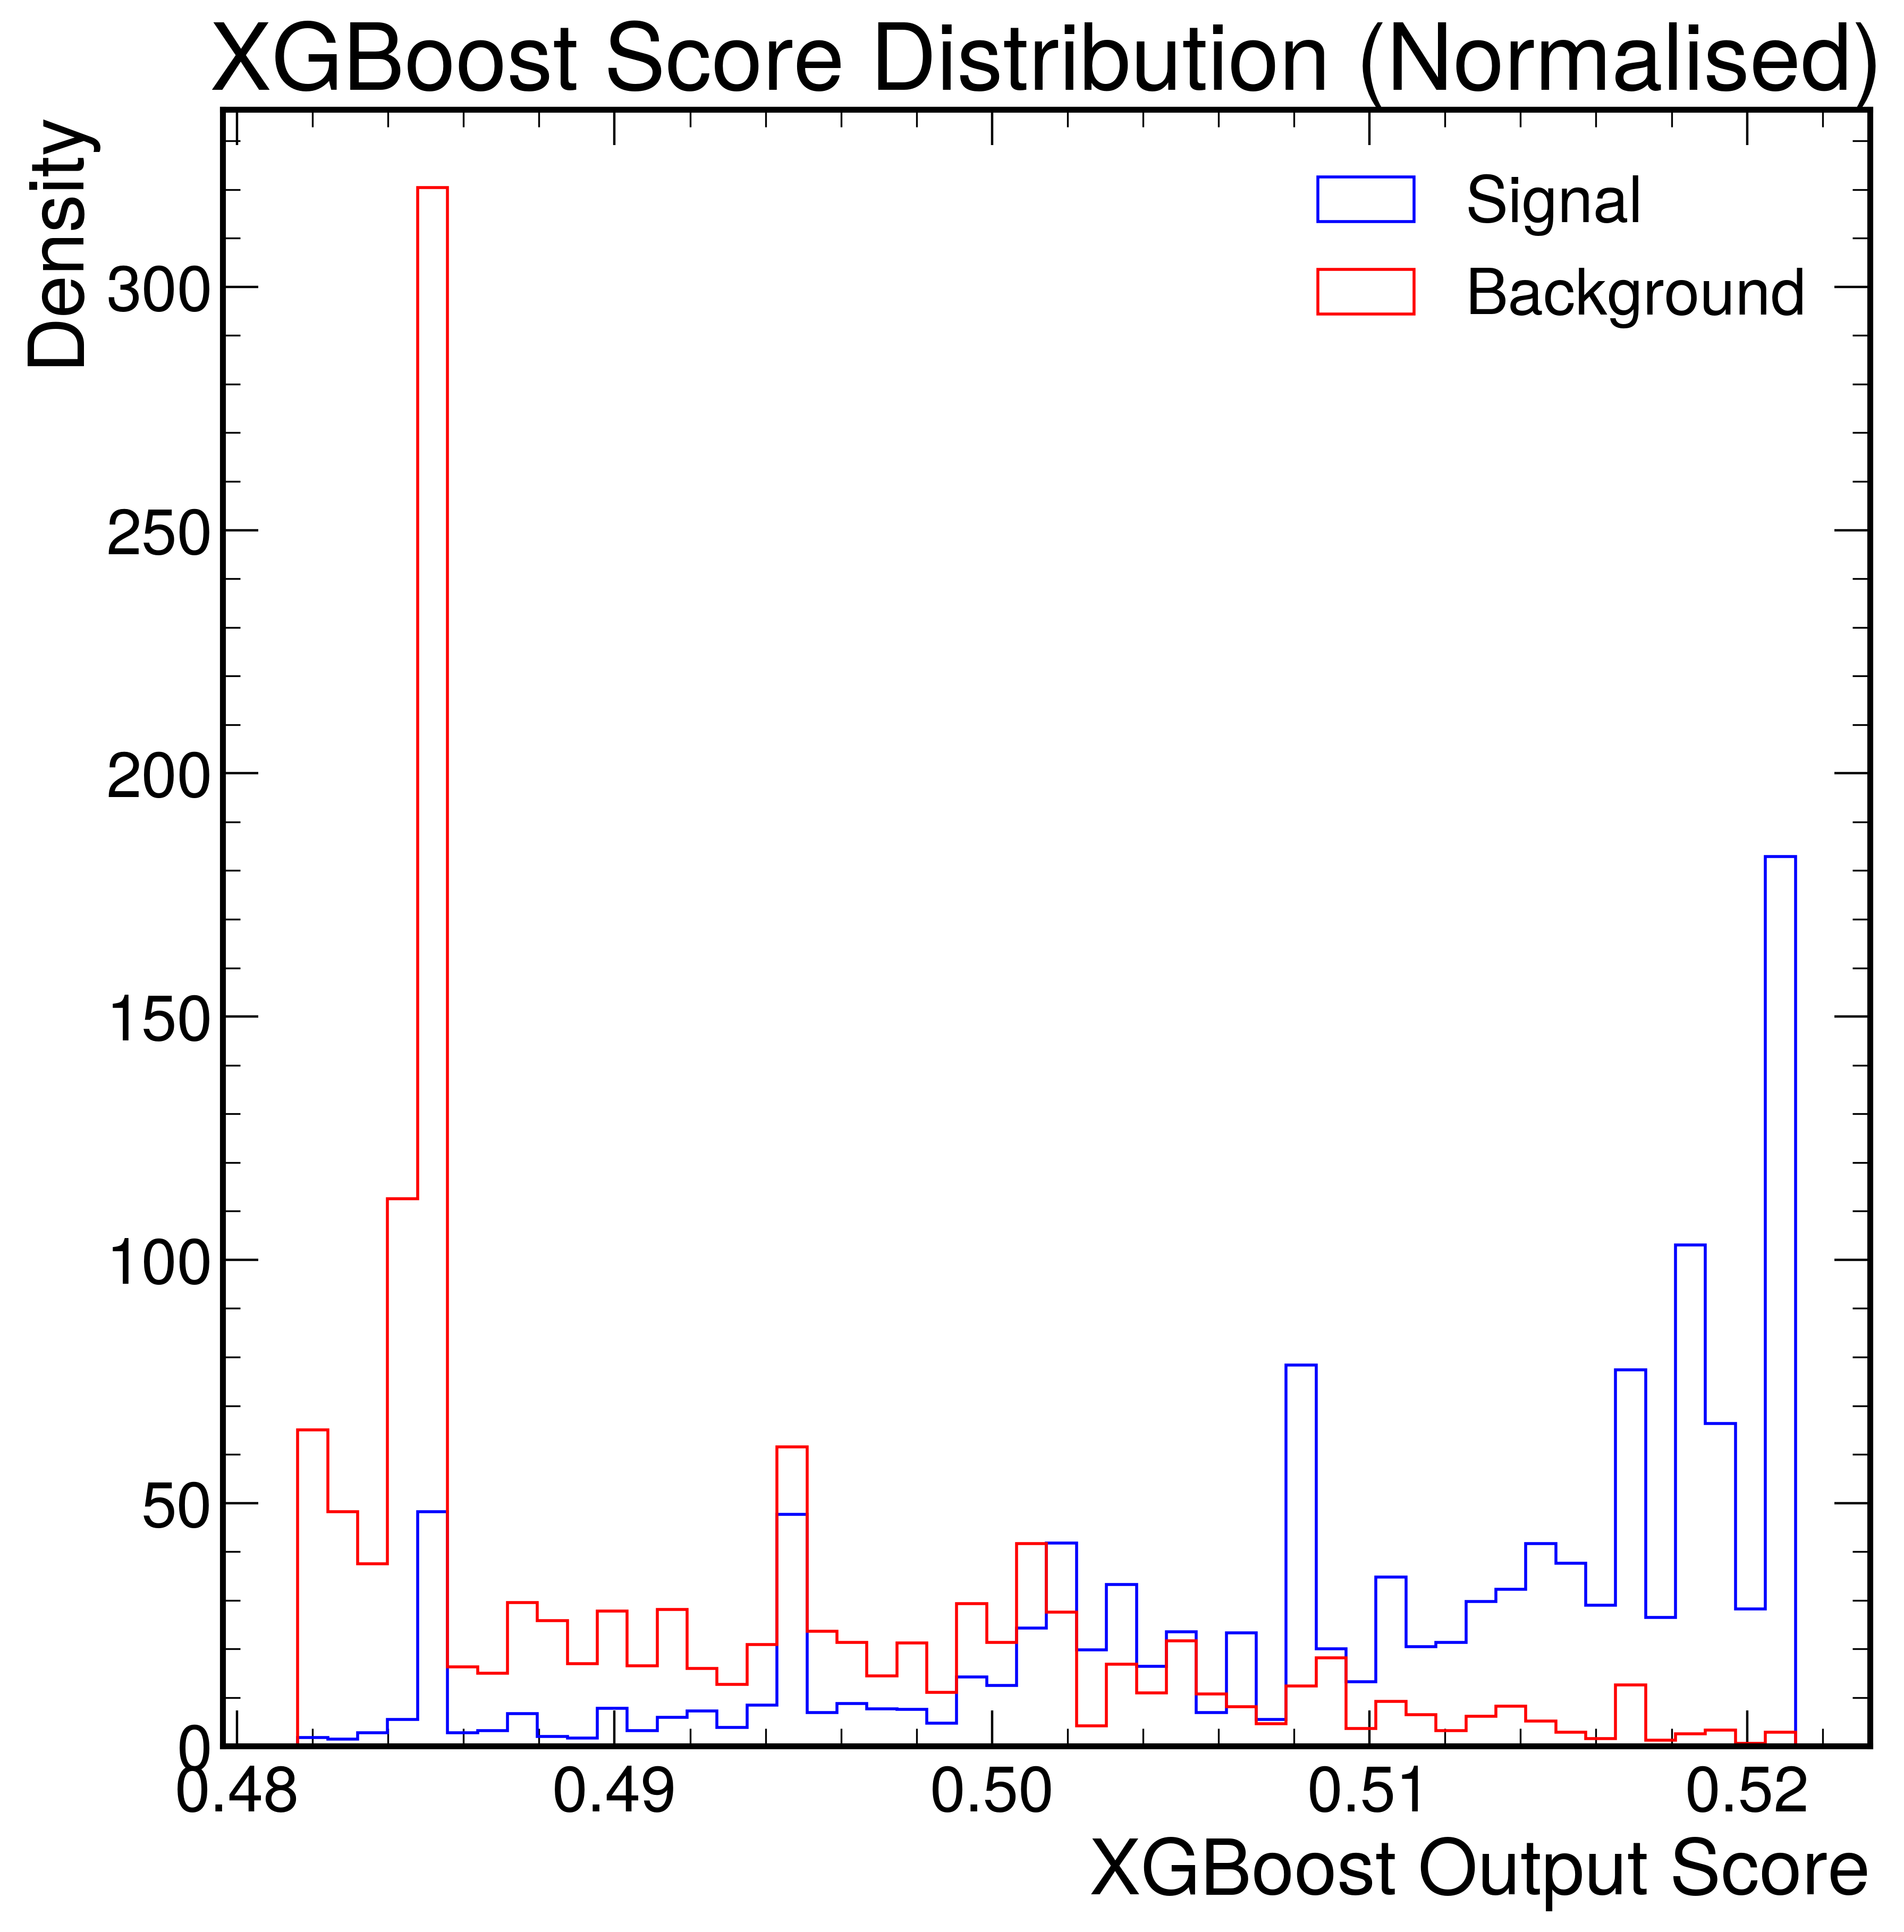

Score distribution saved to test-1/xgb_score_dist_normalised.png


In [58]:
# Plot score distribution for signal and background (normalised)
plt.figure()
plt.hist(
    y_pred[y_test == 1],
    weights=weights_test[y_test == 1],
    bins=50,
    histtype="step",
    color="blue",
    label="Signal",
    density=True  # Normalise histogram
)
plt.hist(
    y_pred[y_test == 0],
    weights=weights_test[y_test == 0],
    bins=50,
    histtype="step",
    color="red",
    label="Background",
    density=True  # Normalise histogram
)
plt.xlabel("XGBoost Output Score")
plt.ylabel("Density")
plt.legend()
plt.title("XGBoost Score Distribution (Normalised)")
plt.savefig(f"{output_dir}/xgb_score_dist_normalised.png")
plt.show()
print(f"Score distribution saved to {output_dir}/xgb_score_dist_normalised.png")

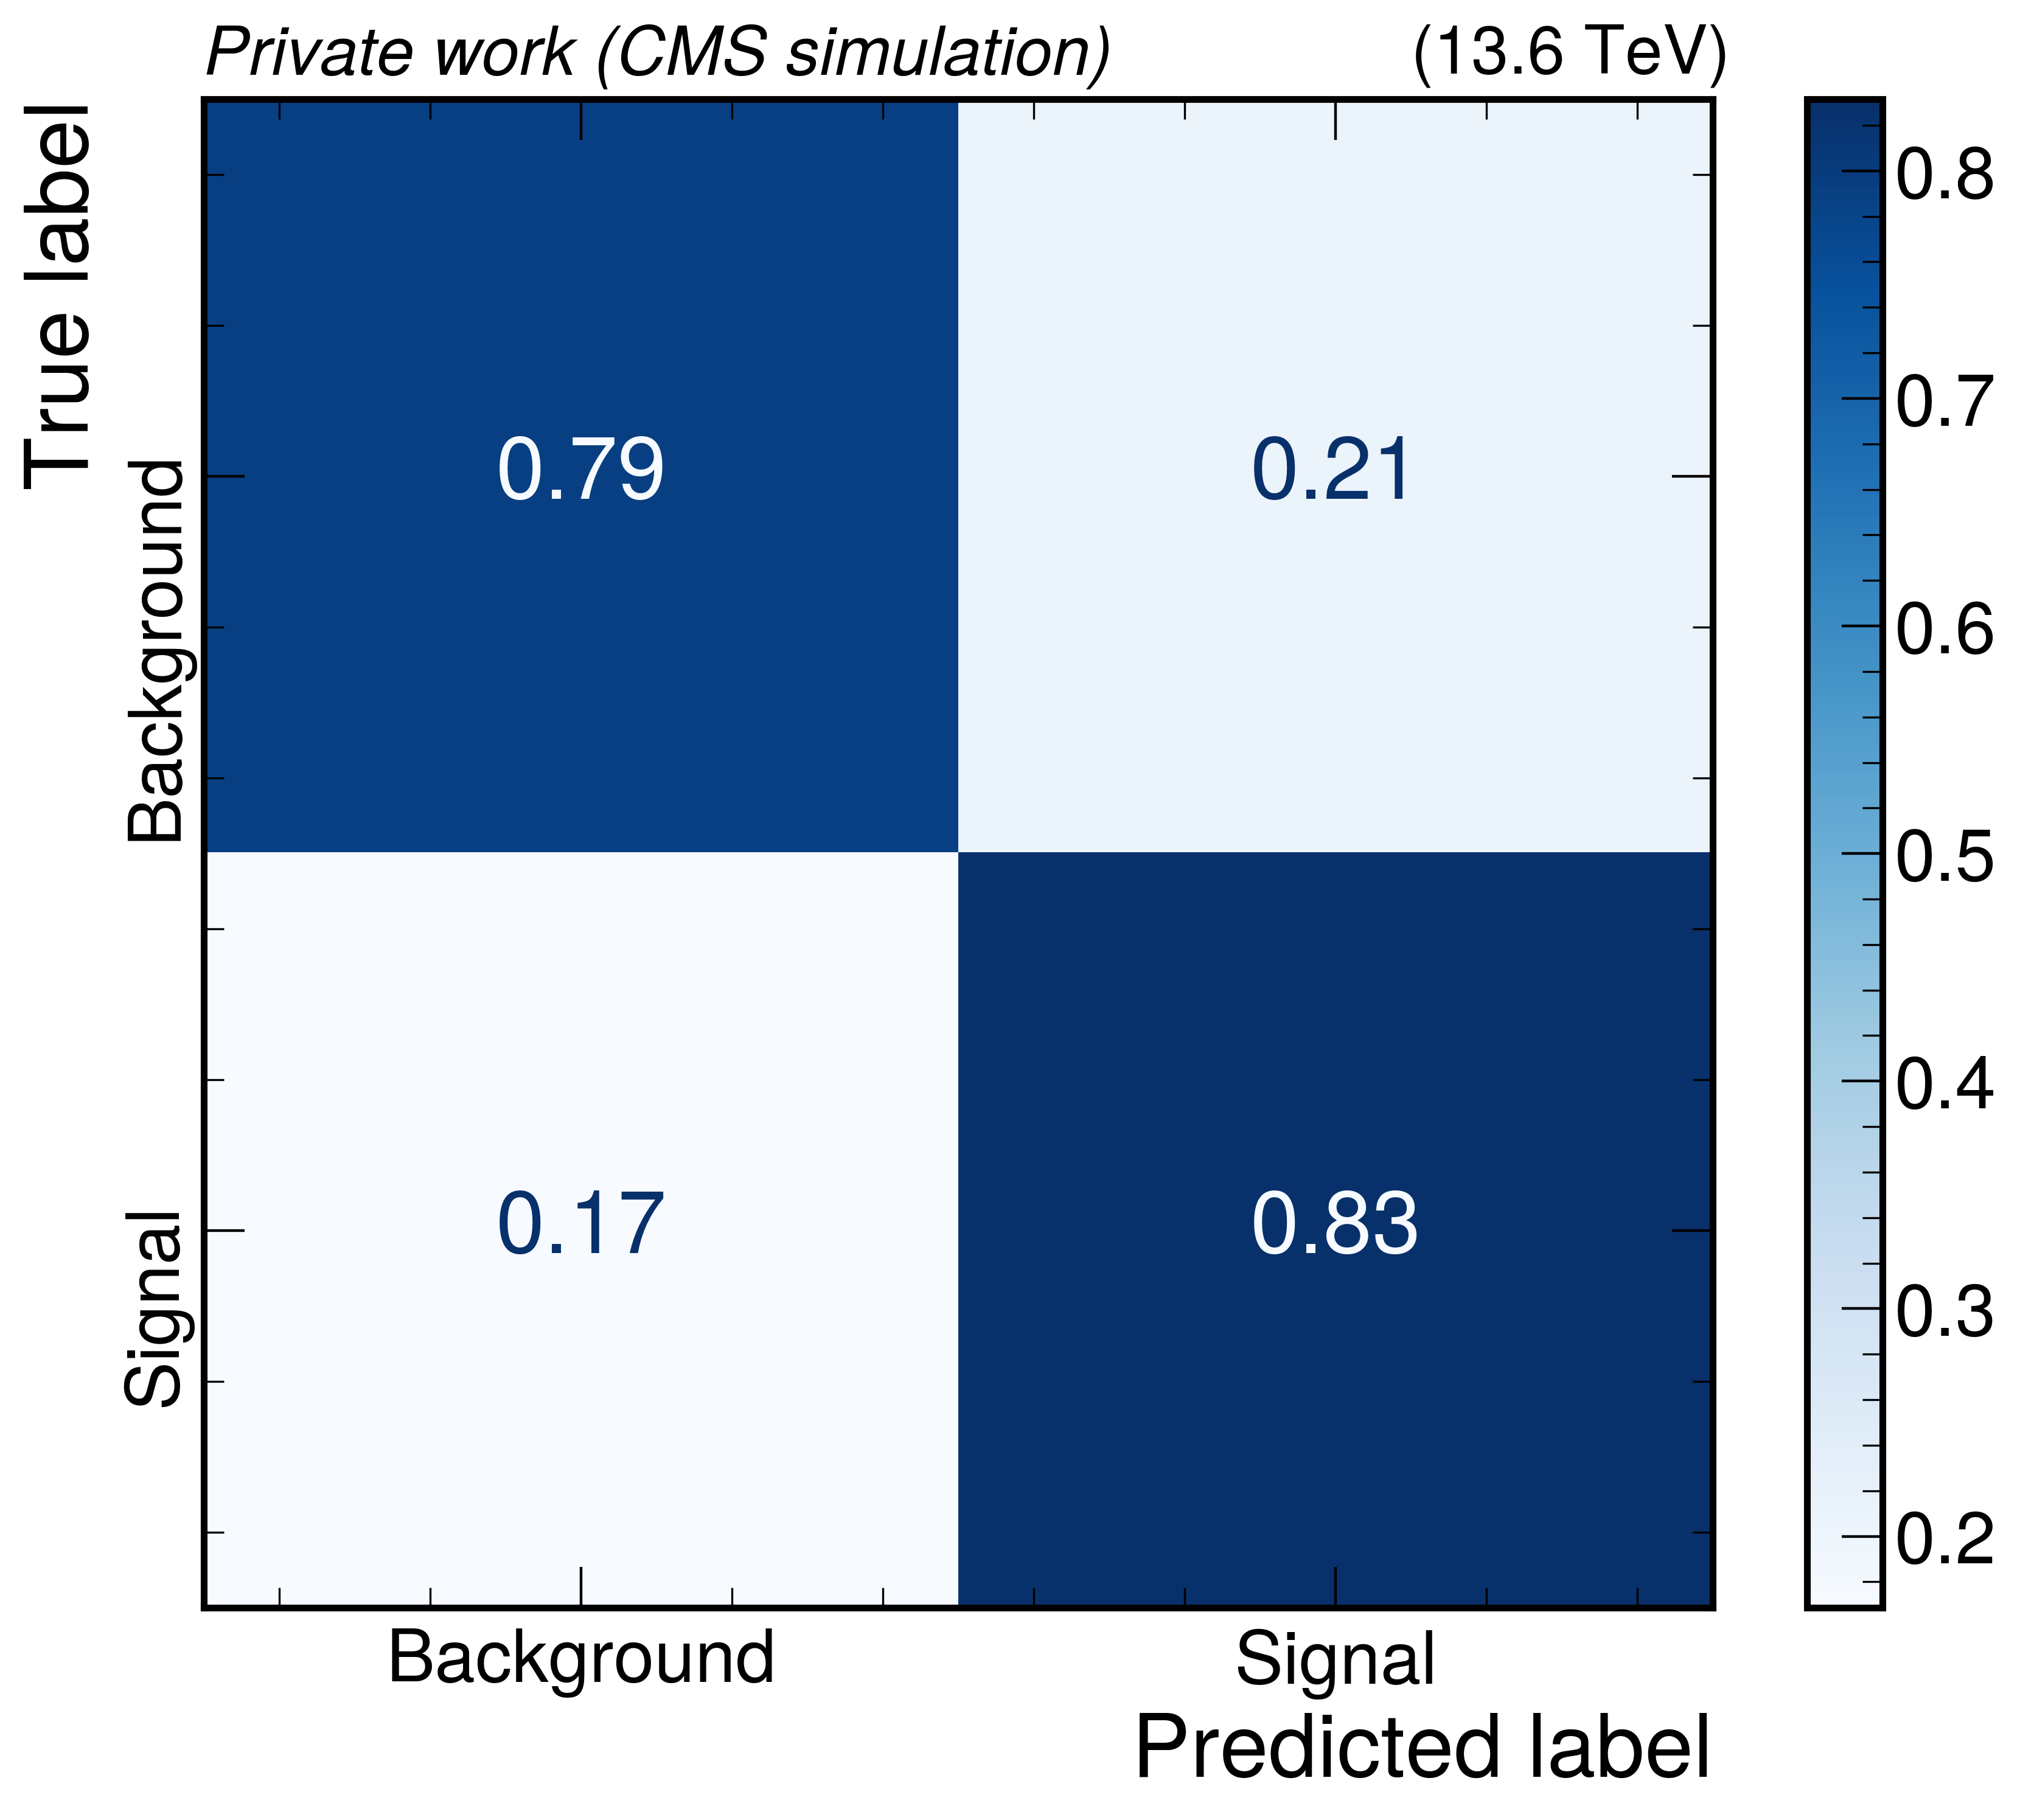

Confusion matrix saved to test-1/xgb_confusion_matrix.png


In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for validation set
y_pred_label = (y_pred > 0.5).astype(int)

# Compute confusion matrix (normalized)
cm = confusion_matrix(
    y_test, y_pred_label, sample_weight=weights_test, normalize="true"
)
display_labels = ["Background", "Signal"]
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=display_labels
)
disp.plot(cmap="Blues", values_format=".2f")
disp.ax_.set_yticklabels(display_labels, rotation=90)

disp.ax_.text(
    0.0,
    1.05,
    "Private work (CMS simulation)",
    fontsize=20,
    fontproperties="Tex Gyre Heros:italic",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)
disp.ax_.text(
    0.8,
    1.05,
    "(13.6 TeV)",
    fontsize=20,
    fontproperties="Tex Gyre Heros",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)

# Adjust colorbar to have the same height as the confusion matrix plot
cbar = disp.figure_.axes[-1]
cbar.set_position(
    [
        cbar.get_position().x0,
        disp.ax_.get_position().y0,
        cbar.get_position().width,
        disp.ax_.get_position().height,
    ]
)
plt.savefig(f"{output_dir}/xgb_confusion_matrix.png")
plt.show()
print(f"Confusion matrix saved to {output_dir}/xgb_confusion_matrix.png")

<Figure size 4000x2400 with 0 Axes>

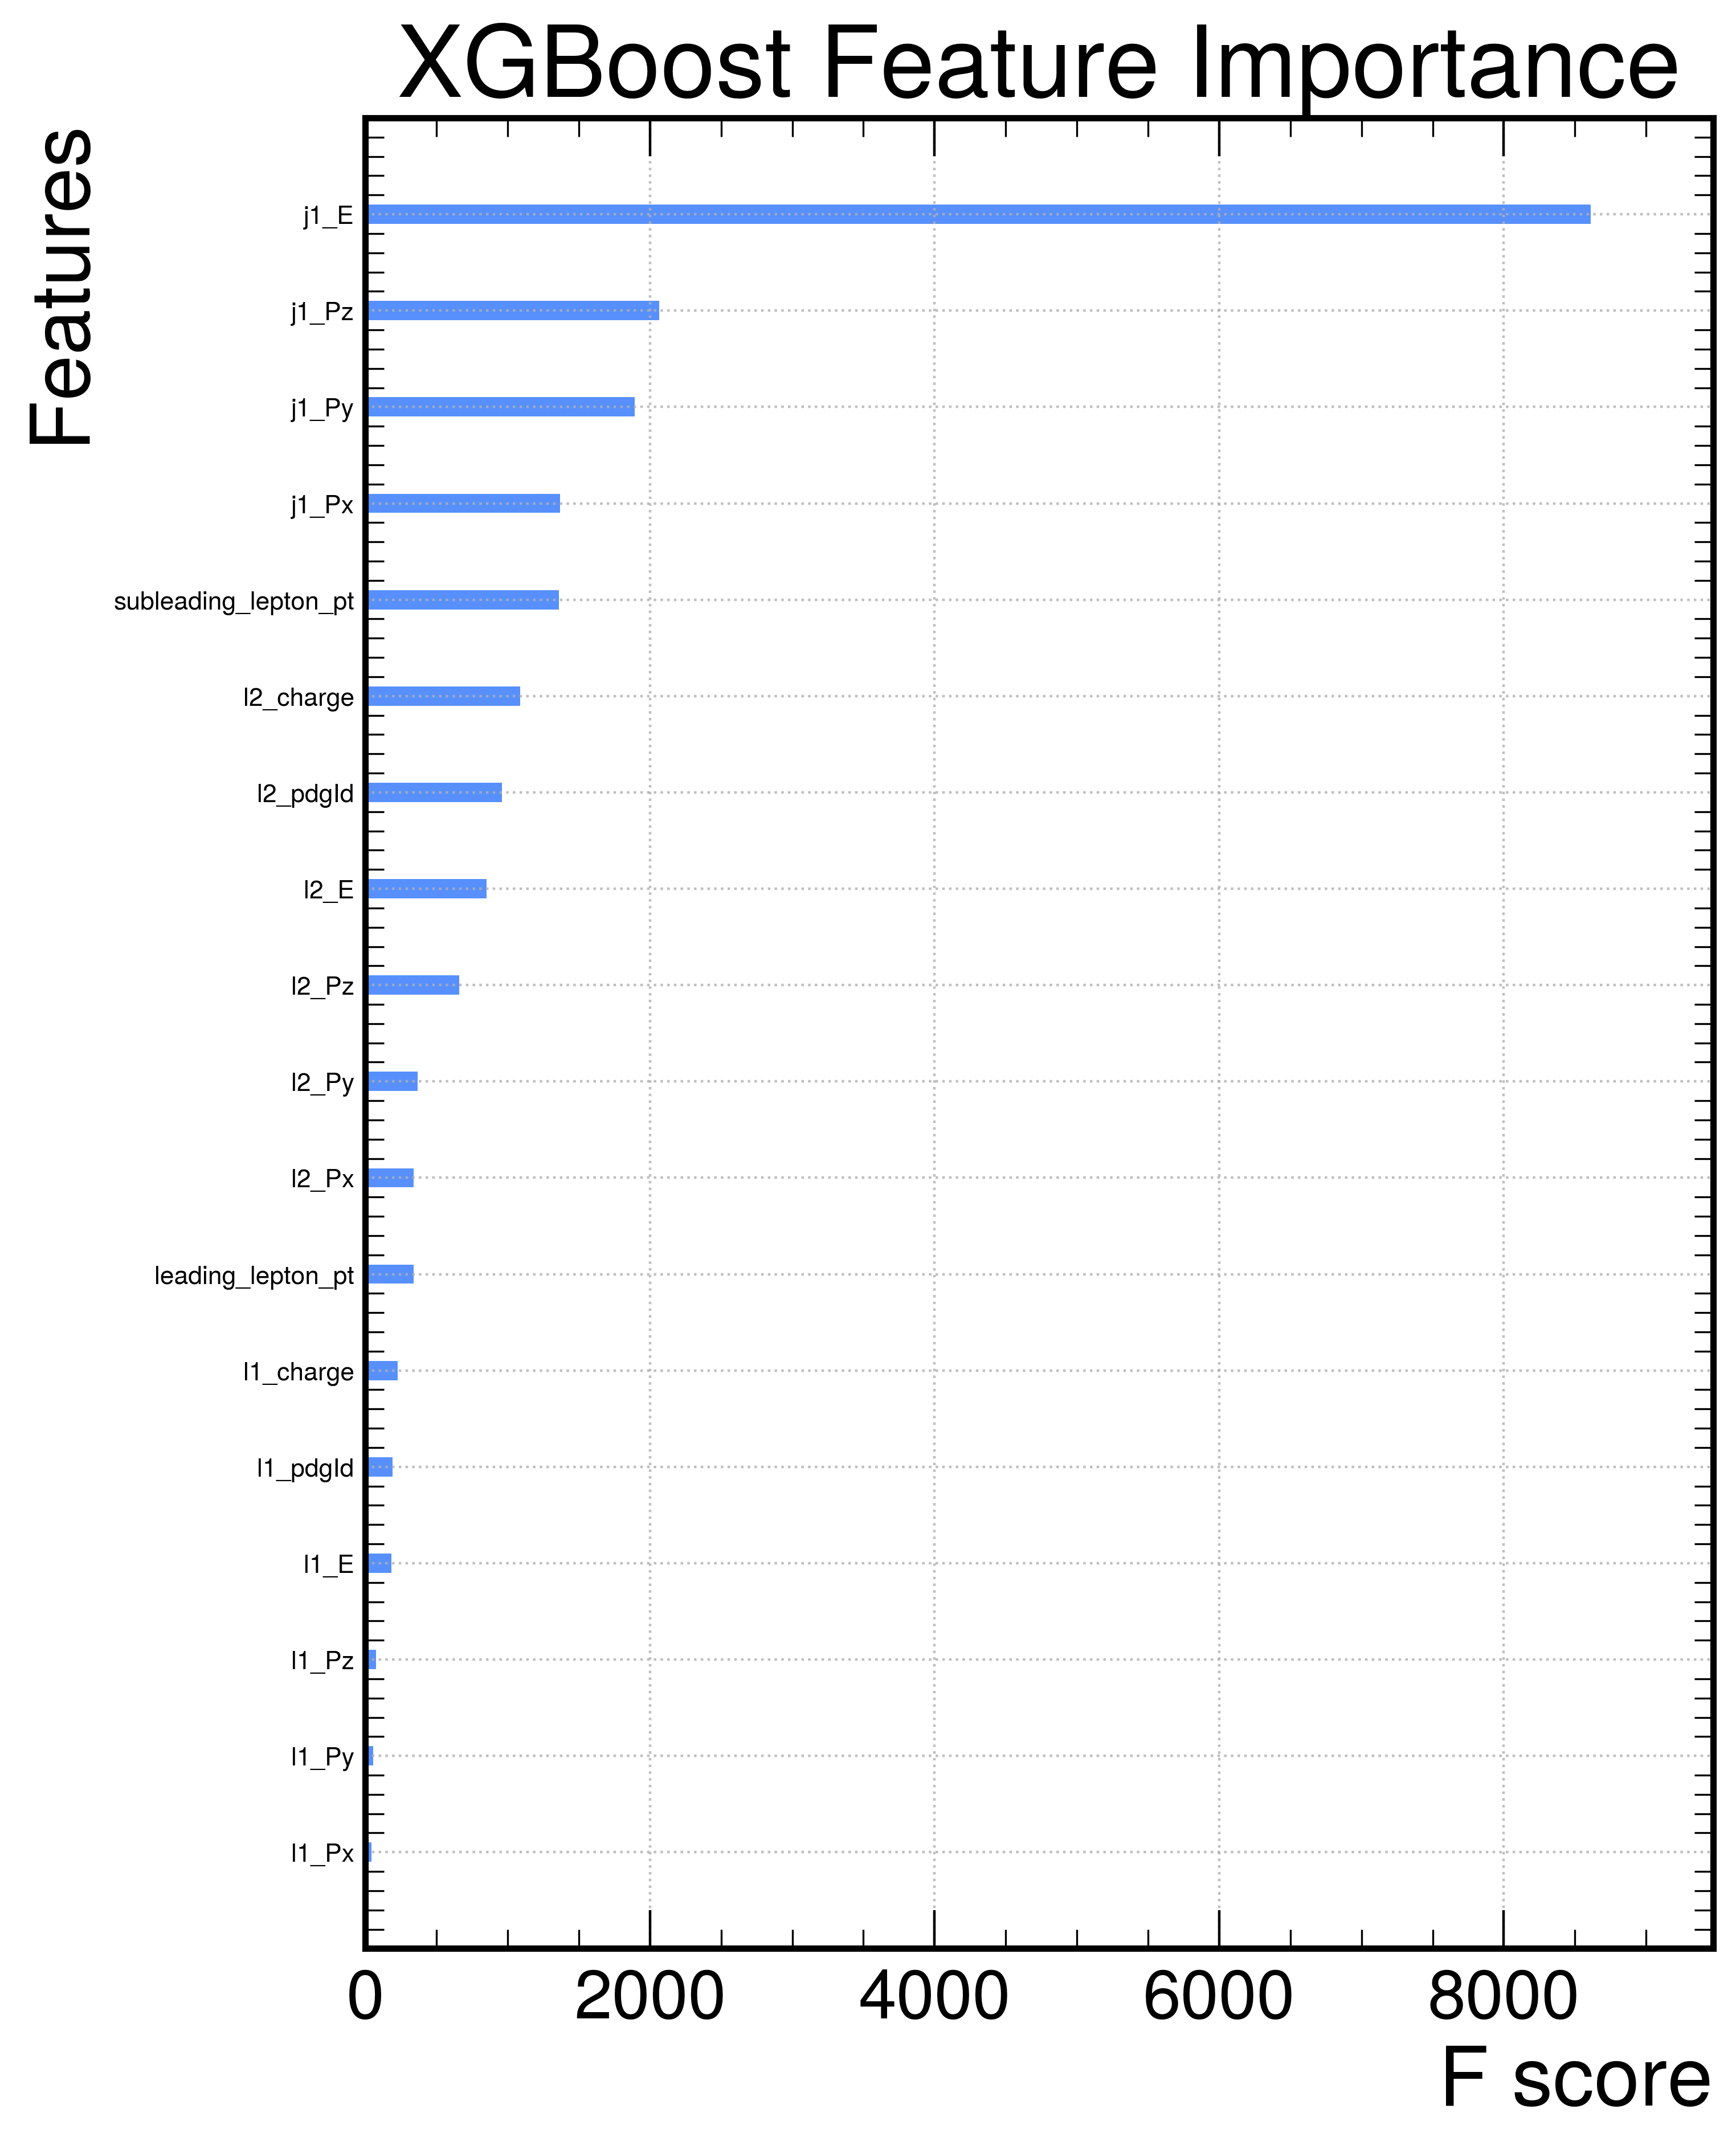

Feature importance plot saved to test-1/xgb_feature_importance.png


In [60]:
from xgboost import plot_importance

# Plot feature importance with feature names
plt.figure(figsize=(10, 6))
ax = plot_importance(
    model,
    max_num_features=len(feature_cols),
    importance_type="gain",
    show_values=False,
)
feature_names = [col for col in df.columns if col not in ["HH", "bkg", "weight"]]
ax.set_yticklabels([feature_names[i] for i in range(len(ax.get_yticklabels()))])
plt.title("XGBoost Feature Importance")
plt.tight_layout()
ax.tick_params(axis="y", labelsize=8, length=0)  # Remove y-axis ticks
plt.savefig(f"{output_dir}/xgb_feature_importance.png")
plt.show()
print(f"Feature importance plot saved to {output_dir}/xgb_feature_importance.png")

In [61]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

onnx_model = onnxmltools.convert_xgboost(
    model,
    initial_types=[("float_input", FloatTensorType([None, X_train.shape[1]]))],
)
onnx_path = f"{output_dir}/model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())
print(f"XGBoost model exported to {onnx_path}")

XGBoost model exported to test-1/model.onnx


In [62]:
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession(onnx_path)
input_name = sess.get_inputs()[0].name
output_names = [o.name for o in sess.get_outputs()]

# Example input: use a real sample from your training data
signal_sample = df[df.HH == 1].sample(n=1000, random_state=seed)[feature_cols].values
bkg_sample = df[df.bkg == 1].sample(n=1000, random_state=seed)[feature_cols].values

signal_outputs = sess.run(output_names, {input_name: signal_sample.astype(np.float32)})
bkg_outputs = sess.run(output_names, {input_name: bkg_sample.astype(np.float32)})
signal_probs = signal_outputs[1]
bkg_probs = bkg_outputs[1]

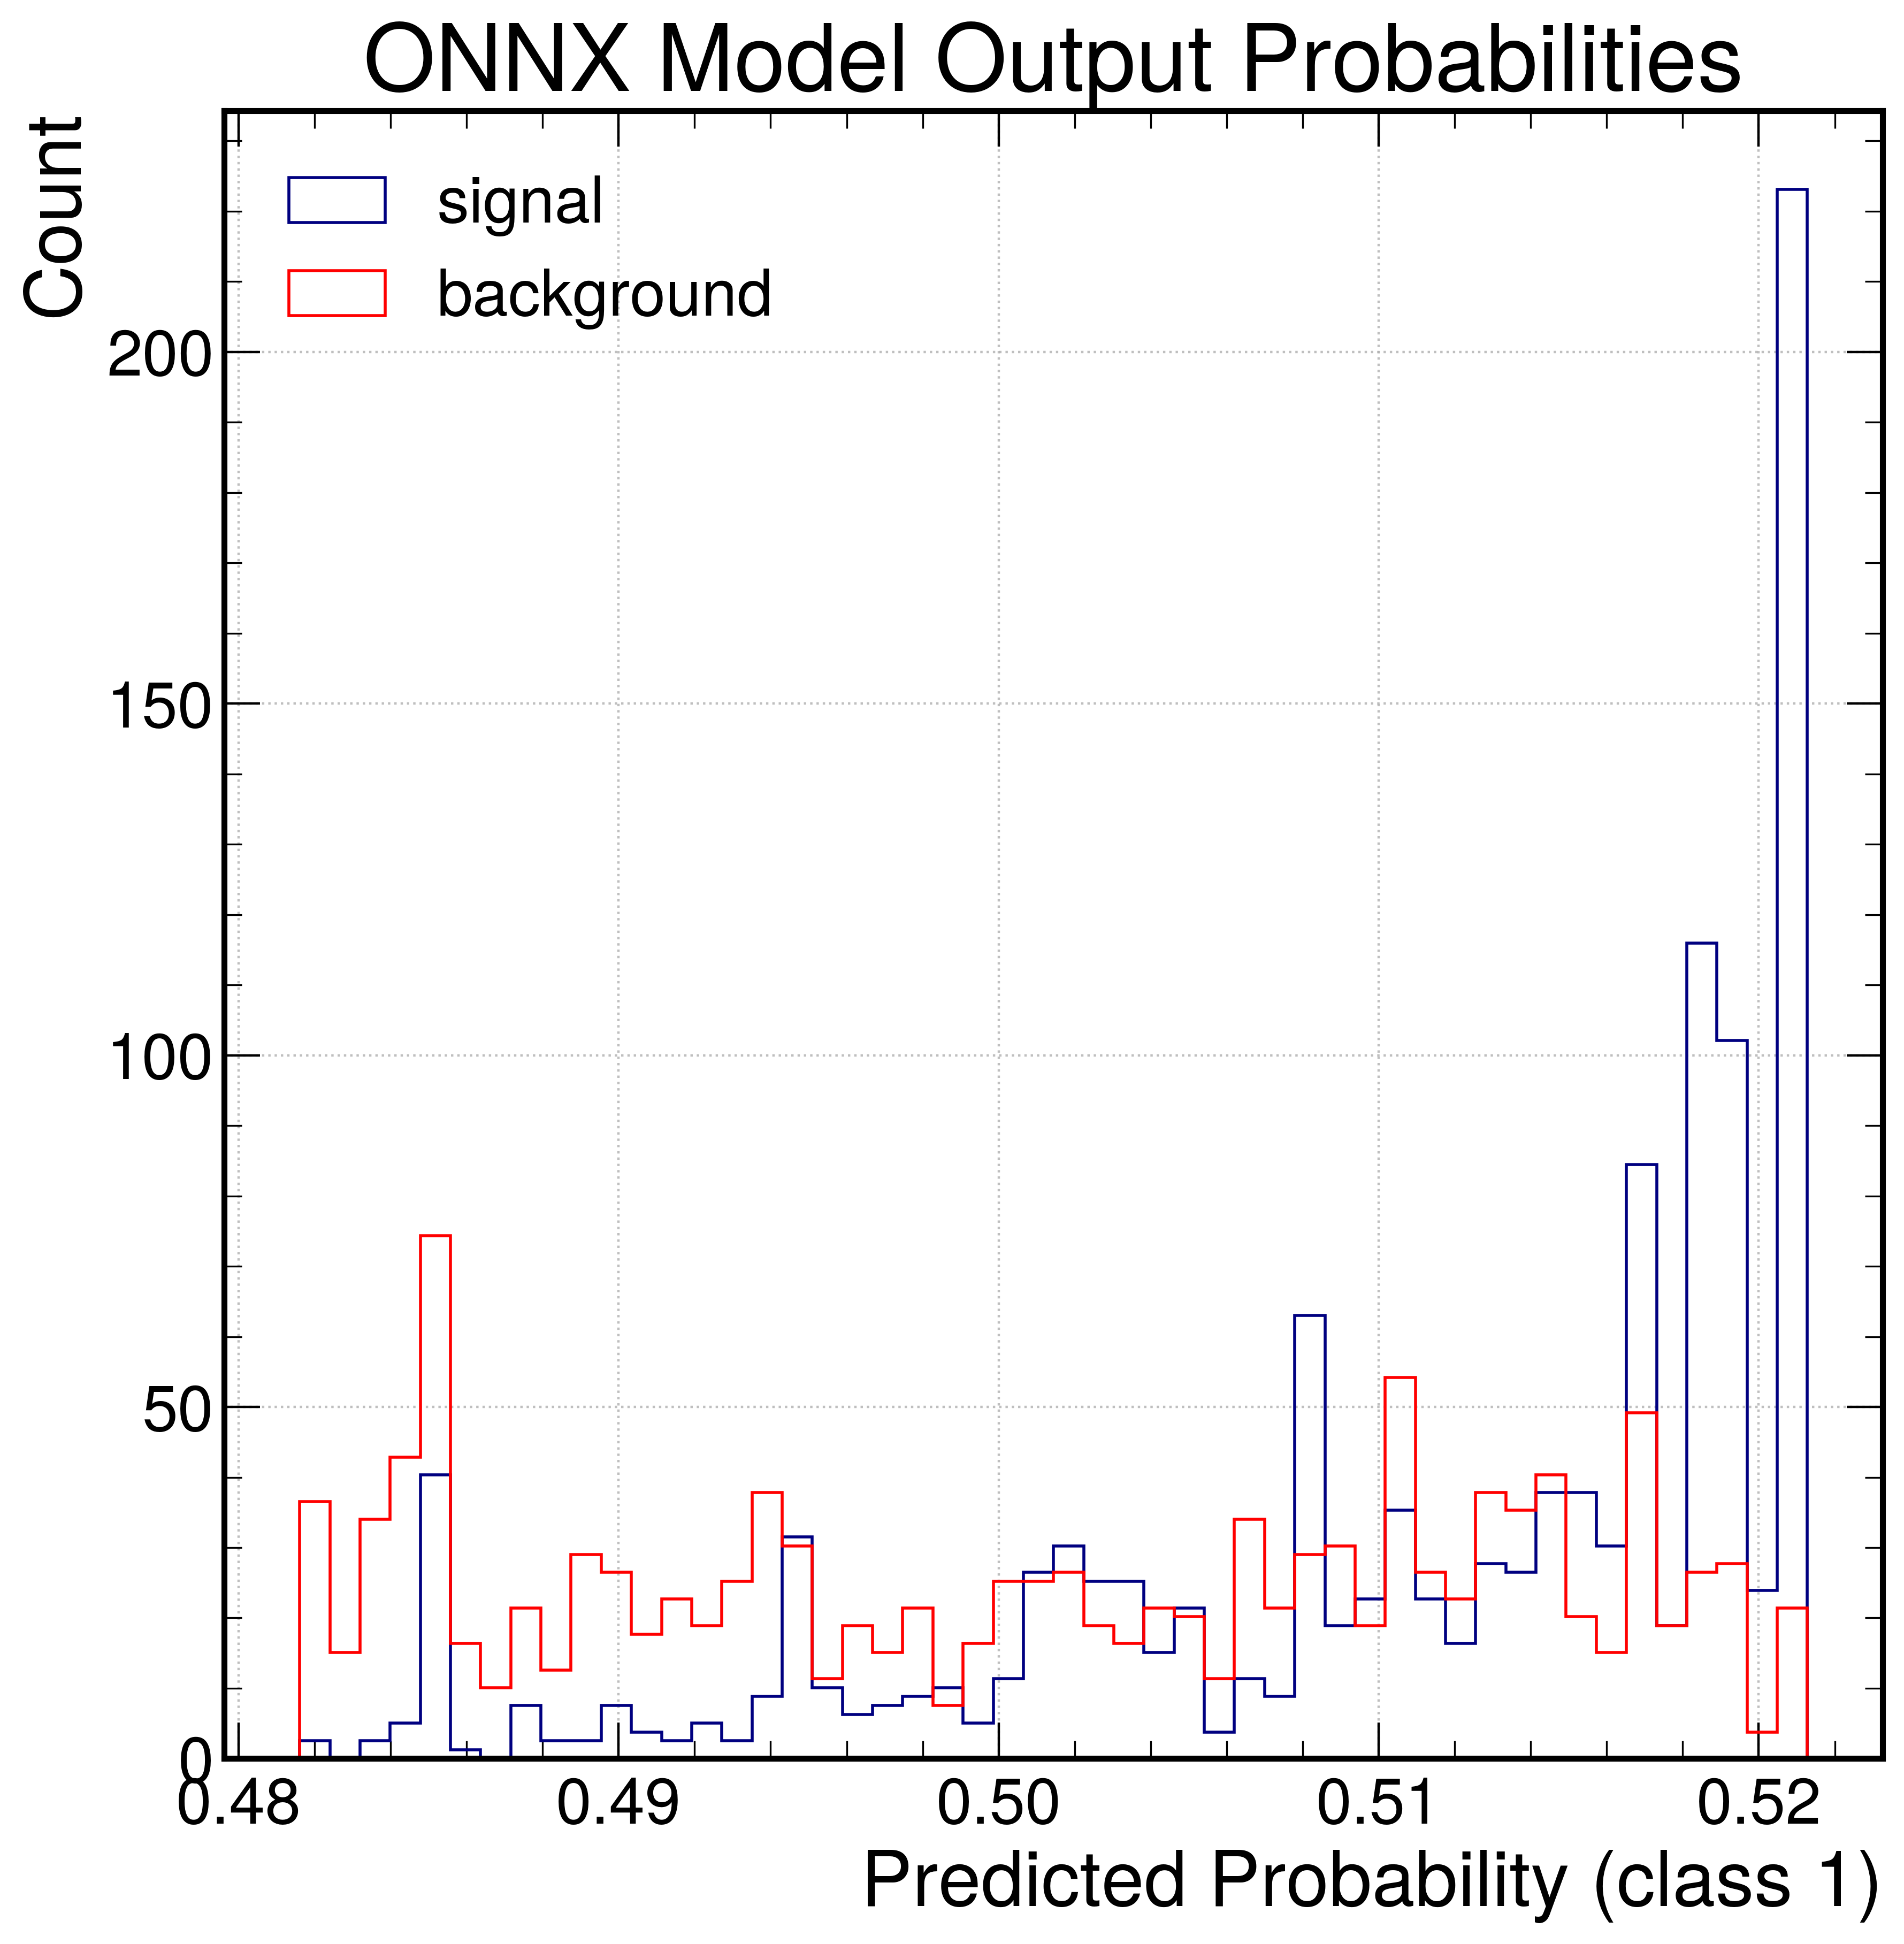

In [63]:
plt.figure()
plt.hist(
    signal_probs[:, 1],
    bins=50,
    color="skyblue",
    histtype="step",
    edgecolor="navy",
    label="signal",
    density=True,
)
plt.hist(
    bkg_probs[:, 1],
    bins=50,
    color="salmon",
    histtype="step",
    edgecolor="red",
    label="background",
    density=True,
)
plt.xlabel("Predicted Probability (class 1)")
plt.ylabel("Count")
plt.title("ONNX Model Output Probabilities")
plt.grid(True)
plt.legend()
plt.show()

In [64]:
# import nbformat
# from nbconvert import PythonExporter

# notebook_path = "XGBoost.ipynb"
# script_path = "XGBoost.py"

# with open(notebook_path, "r", encoding="utf-8") as f:
#     nb = nbformat.read(f, as_version=4)

# python_exporter = PythonExporter()
# script_body, _ = python_exporter.from_notebook_node(nb)

# with open(script_path, "w", encoding="utf-8") as f:
#     f.write(script_body)

# print(f"Notebook converted to Python script: {script_path}")